<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Временные-ряды" data-toc-modified-id="Временные-ряды-1">Временные ряды</a></span><ul class="toc-item"><li><span><a href="#1.-Визуальный-анализ-и-предобработка" data-toc-modified-id="1.-Визуальный-анализ-и-предобработка-1.1">1. Визуальный анализ и предобработка</a></span></li><li><span><a href="#2.-Стабилизация-дисперсии" data-toc-modified-id="2.-Стабилизация-дисперсии-1.2">2. Стабилизация дисперсии</a></span></li><li><span><a href="#3.-Дифференцирование" data-toc-modified-id="3.-Дифференцирование-1.3">3. Дифференцирование</a></span></li><li><span><a href="#4.-Выбор-начальных-значений-для-$p,q$-и-$P,Q$." data-toc-modified-id="4.-Выбор-начальных-значений-для-$p,q$-и-$P,Q$.-1.4">4. Выбор начальных значений для $p,q$ и $P,Q$.</a></span></li><li><span><a href="#5.-Перебор-и-сравнение-моделей-для-всех-$p,q$-и-$P,Q$,-которые-меньше-или-равны-начальным-значениям" data-toc-modified-id="5.-Перебор-и-сравнение-моделей-для-всех-$p,q$-и-$P,Q$,-которые-меньше-или-равны-начальным-значениям-1.5">5. Перебор и сравнение моделей для всех $p,q$ и $P,Q$, которые меньше или равны начальным значениям</a></span></li><li><span><a href="#6.-Анализ-остатков" data-toc-modified-id="6.-Анализ-остатков-1.6">6. Анализ остатков</a></span><ul class="toc-item"><li><span><a href="#График-модель-+-ряд" data-toc-modified-id="График-модель-+-ряд-1.6.1">График модель + ряд</a></span></li><li><span><a href="#Прогноз" data-toc-modified-id="Прогноз-1.6.2">Прогноз</a></span></li></ul></li></ul></li><li><span><a href="#Как-можно-генерировать-лаговые-переменные" data-toc-modified-id="Как-можно-генерировать-лаговые-переменные-2">Как можно генерировать лаговые переменные</a></span></li><li><span><a href="#Как-можно-делать-кросс-валидацию" data-toc-modified-id="Как-можно-делать-кросс-валидацию-3">Как можно делать кросс-валидацию</a></span></li></ul></div>

## Временные ряды

Давайте посмотрим, как подгонять модель SARIMA(p,d,q)x(P,D,Q) под временной ряд и анализировать качество полученной модели.

In [1]:
# Как обычно, начнем с импорта стандартных библиотек
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
plt.rcParams["figure.figsize"] = (20,12)

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
plt.style.use('ggplot')

In [6]:
import statsmodels.api as sm # все, для работы с рядами
from scipy.special import inv_boxcox # обратное преобразование Бокса-Кокса 
from itertools import product # произведения множеств
import warnings # чтобы отключить предупреждения в Python

**Задача.** В файле **wine.csv** содержаться данные о месячных продажах вина в Австралии. Требуется оценить выбрать оптимальную по AIC критерию модель SARIMA и построить прогноз продаж на следующие 3 года.

In [7]:
data = pd.read_csv("wine.csv", sep=',') 
data

,month,sales
0,1980-01-01,15136
1,1980-02-01,16733
2,1980-03-01,20016
3,1980-04-01,17708
4,1980-05-01,18019
...,...,...
171,1994-04-01,26323
172,1994-05-01,23779
173,1994-06-01,27549
174,1994-07-01,29660


In [8]:
# импортируем данные
# здесь еще мы дополнительно сделали столбец 'month' индексом,
# преобразовали его содержимое в тип "дата" и указали, что у нас не американский формат даты (сначала ) 

data = pd.read_csv("wine.csv", sep=',', 
                   index_col=['month'], parse_dates=['month'], dayfirst=False) 

data.head()

,sales
month,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


In [9]:
data.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '1993-11-01', '1993-12-01', '1994-01-01', '1994-02-01',
               '1994-03-01', '1994-04-01', '1994-05-01', '1994-06-01',
               '1994-07-01', '1994-08-01'],
              dtype='datetime64[ns]', name='month', length=176, freq=None)

In [10]:
data.index.month

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            11, 12,  1,  2,  3,  4,  5,  6,  7,  8],
           dtype='int64', name='month', length=176)

In [11]:
data['lag_2']= data['sales'].shift(2)
data['lag_12']= data['sales'].shift(12)

In [12]:
data.head(20)

,sales,lag_2,lag_12
month,,,
1980-01-01,15136,NaN,NaN
1980-02-01,16733,NaN,NaN
1980-03-01,20016,15136.0,NaN
1980-04-01,17708,16733.0,NaN
1980-05-01,18019,20016.0,NaN
1980-06-01,19227,17708.0,NaN
1980-07-01,22893,18019.0,NaN
1980-08-01,23739,19227.0,NaN
1980-09-01,21133,22893.0,NaN


In [13]:
data.corr()

,sales,lag_2,lag_12
sales,1.000000,-0.143928,0.872311
lag_2,-0.143928,1.000000,-0.155535
lag_12,0.872311,-0.155535,1.000000


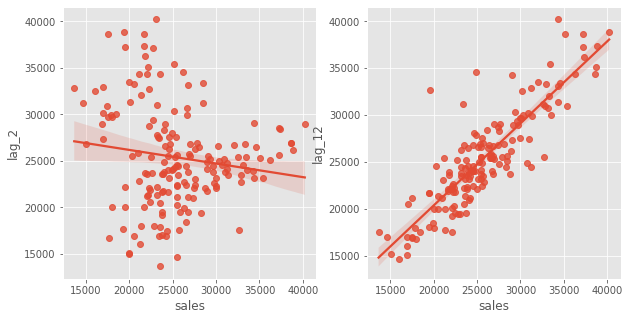

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(121); sns.regplot(data=data, x='sales', y='lag_2')
plt.subplot(122); sns.regplot(data=data, x='sales', y='lag_12')
plt.show()

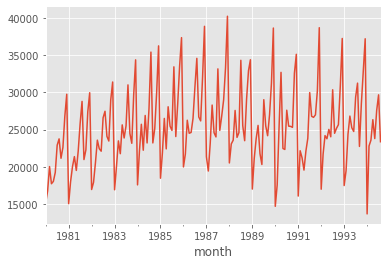

In [15]:
data['sales'].plot();

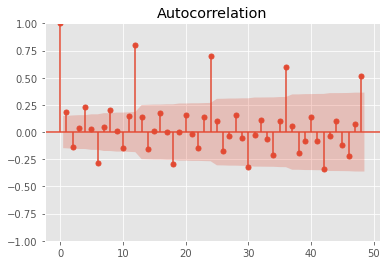

In [16]:
sm.graphics.tsa.plot_acf(data['sales'], lags=48);

In [17]:
data.shape[0]/12

14.666666666666666

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


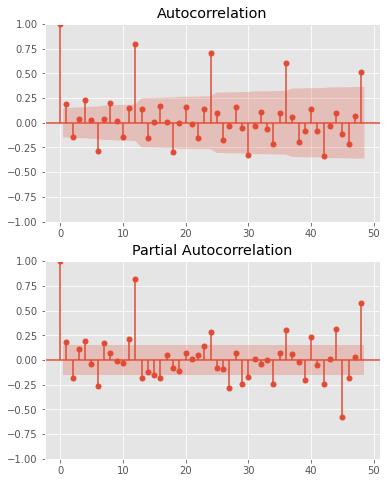

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(6,8)) 

sm.graphics.tsa.plot_acf(data['sales'], lags=48, ax=ax1)
sm.graphics.tsa.plot_pacf(data['sales'], lags=48, ax=ax2)

plt.show()

In [19]:
for i in range(49):
    data[f'lag_{i}'] = data['sales'].shift(i)

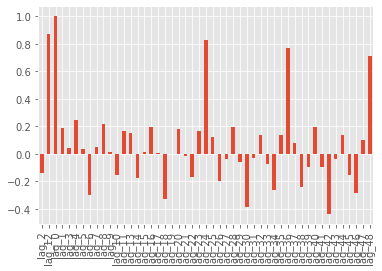

In [20]:
data.corr()['sales'][1:].plot(kind='bar');

In [21]:
np.abs(data.corr()['sales']).sort_values(ascending=False)[:8]#.plot()

sales     1.000000
lag_0     1.000000
lag_12    0.872311
lag_24    0.829398
lag_36    0.766949
lag_48    0.709832
lag_42    0.437831
lag_30    0.387452
Name: sales, dtype: float64

### 1. Визуальный анализ и предобработка

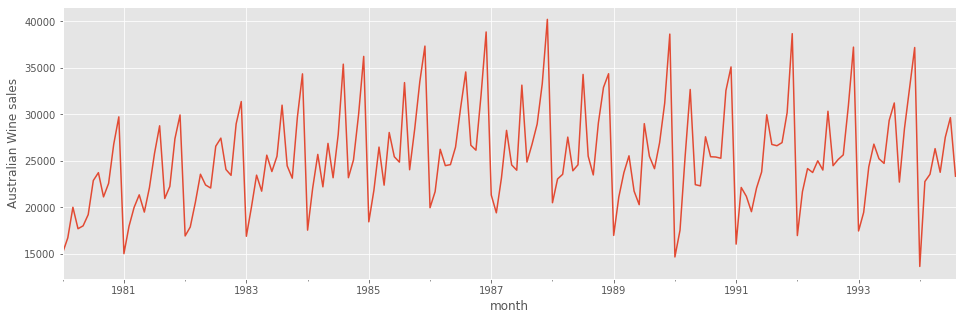

In [22]:
plt.figure(figsize=(16,5))
data.sales.plot()
plt.ylabel('Australian Wine sales')
plt.show()

In [23]:
data.sales.isnull().sum()

0

In [24]:
# # data.sales.fillna()
# pad / ffill: propagate last valid observation forward to next valid
# backfill / bfill: use next valid observation to fill gap.

In [25]:
176 / 12

14.666666666666666

Мы видим, что временной ряд не содержит пропуски. Начало ряда не сильно отличается от конца ряда, поэтому мы ничего удалять не будем. У ряда видна очевидная годовая сезонность (больше всего вина продается в декабре, меньше всего — в январе). Кроме этого, есть возможный цикл или меняющийся тренд. Наконец, дисперсия ряда увеличивается со временем.  

Удобный инструмент для визуального анализа ряда — его **STL-декомпозиция**. STL расшифровывается как A Seasonal-Trend Decomposition Procedure Based on Loess, и это процедура декомпозиции временного ряда на сезонную, трендовую составляющие и на остатки, использующую метод локальных регрессий (LOESS). И именно с помощью LOESS и происходит сглаживание исходного ряда данных.

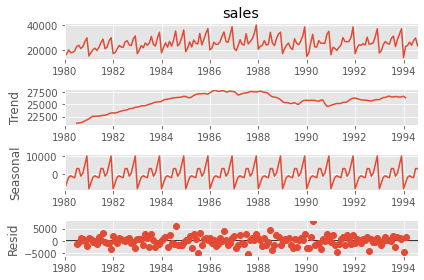

In [26]:
sm.tsa.seasonal_decompose(data.sales).plot()#figsize=(20,8))
plt.show()

In [27]:
res = sm.tsa.seasonal_decompose(data.sales)

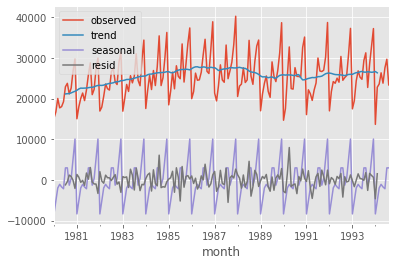

In [28]:
res.observed.plot(label='observed')
res.trend.plot(label='trend')
res.seasonal.plot(label='seasonal')
res.resid.plot(label='resid')

plt.legend()
plt.show()

### 2. Стабилизация дисперсии

Стабилизировать дисперсию мы будем с помощью преобразованися Бокса-Кокса. В Python реализовано это преобразование с автоматичесим подбором параметра $\lambda$. Им мы и воспользуемся. Преобразованный ряд запишем в тот же DataFrame.

In [29]:
data['sales_boxcox'], lmbd = stats.boxcox(data['sales'])

In [30]:
print("Оптимальный параметр преобразования Бокса-Кокса: ",lmbd)

Оптимальный параметр преобразования Бокса-Кокса:  0.23667537162383442


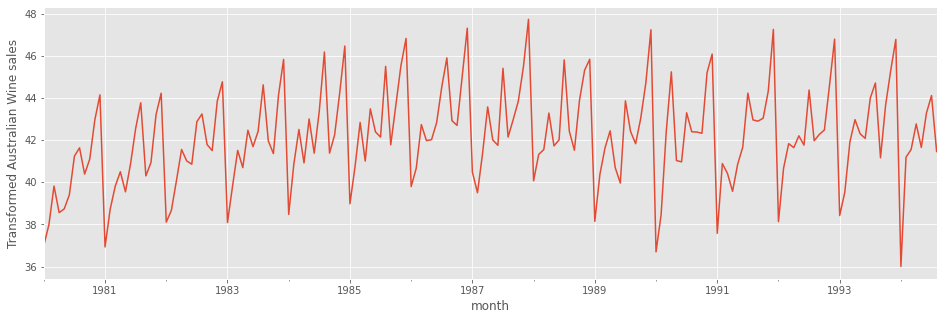

In [31]:
plt.figure(figsize(16,5))
data.sales_boxcox.plot()
plt.ylabel('Transformed Australian Wine sales')
plt.show()

После преобразования Бокса-Кокса дисперсия ряда стала более стабильной. Посмотрим на STL-декомпозицию преобразованного ряда.

<Figure size 1152x576 with 0 Axes>

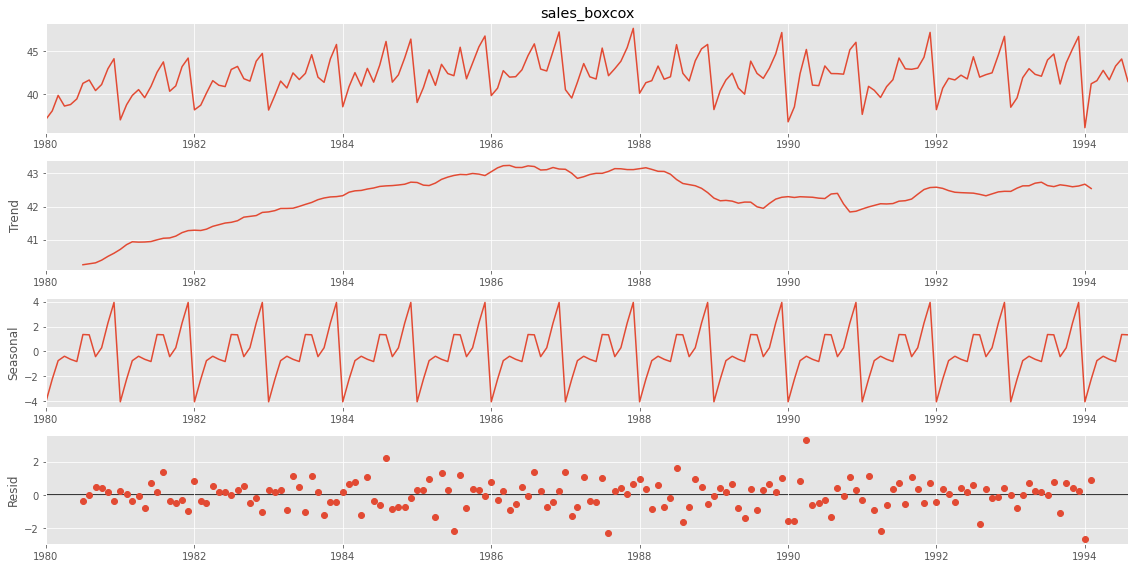

In [32]:
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(data.sales_boxcox).plot()
plt.show()

### 3. Дифференцирование

По построенным графикам видно, что данные обладают сезонностью и, возможно, трендом, который необходимо удалить. Этот шаг необходим, чтобы сделать ряд стационарным и подогнать к нему модель SARMA (у нас есть гарантии, что эта модель хорошо описывает только стационарные ряды). Как было сказано на лекции: лучше всего начинать с сезонного дифференцирования.

In [33]:
data['sales_boxcox_diff'] = data.sales_boxcox - data.sales_boxcox.shift(12)

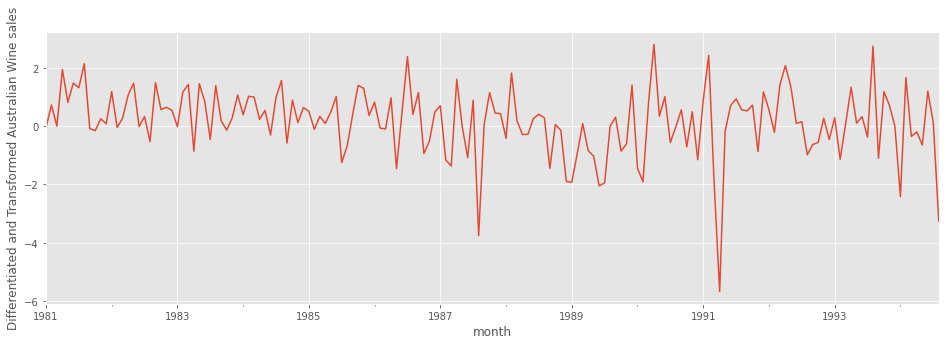

In [34]:
plt.figure(figsize(16,5))
data.sales_boxcox_diff[12:].plot()
plt.ylabel('Differentiated and Transformed Australian Wine sales')
plt.show()

<Figure size 1152x576 with 0 Axes>

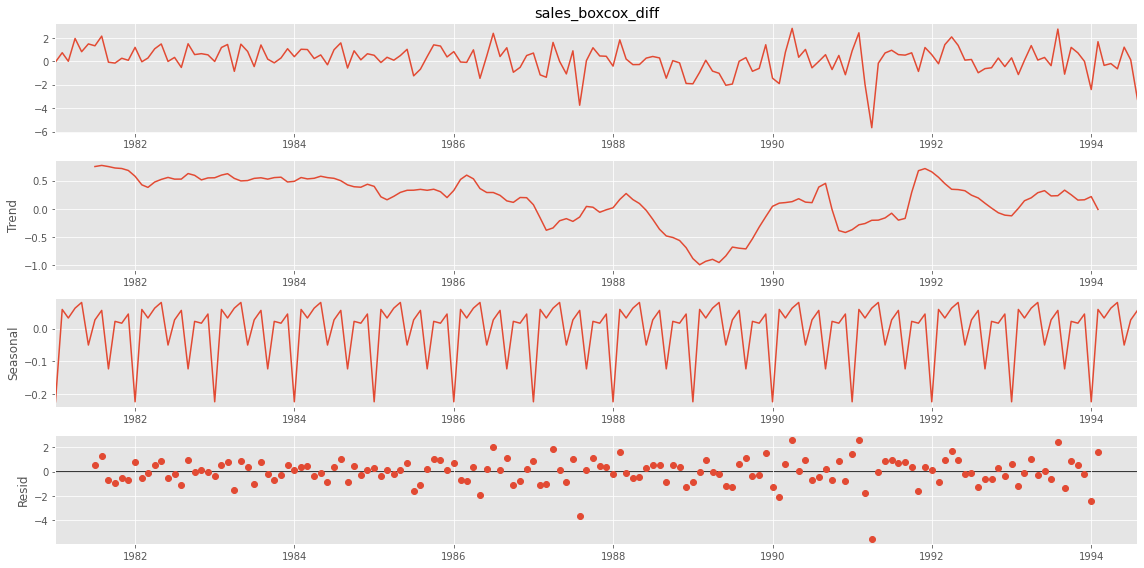

In [35]:
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(data.sales_boxcox_diff[12:]).plot()
plt.show()

Видим, что после сезонного дифференцирования пропала только сезонность, но ряд не стал стационарным  (например, потому что у него есть заметный тренд). Сделаем еще одно обычное дифференцирование.

In [36]:
data['sales_boxcox_diff2'] = data.sales_boxcox_diff - data.sales_boxcox_diff.shift(1)

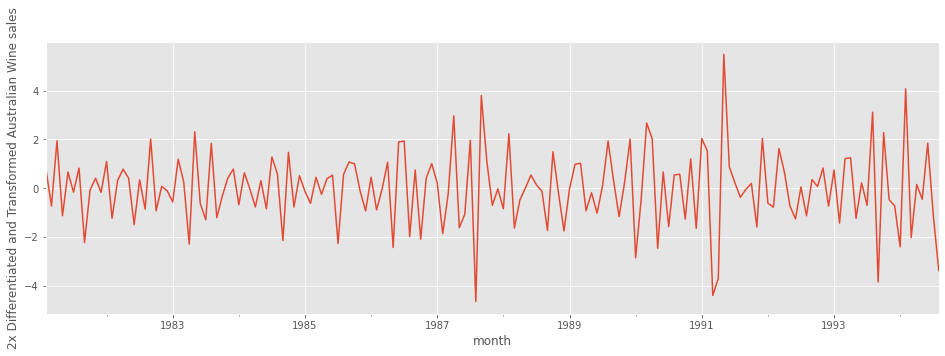

In [37]:
plt.figure(figsize(16,5))
data.sales_boxcox_diff2[13:].plot()
plt.ylabel('2x Differentiated and Transformed Australian Wine sales')
plt.show()

<Figure size 1152x576 with 0 Axes>

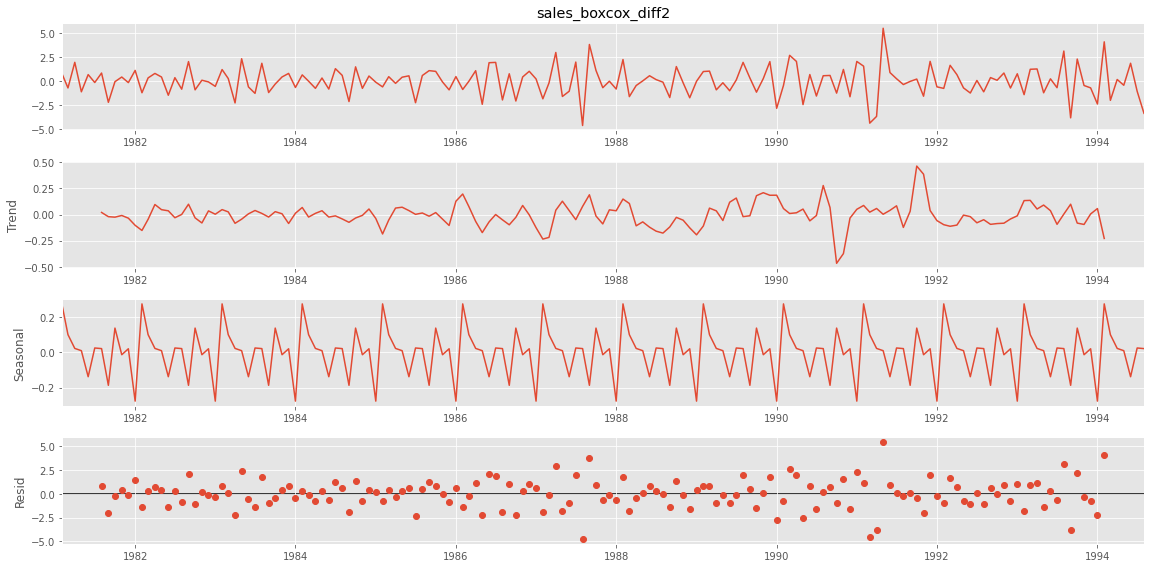

In [38]:
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(data.sales_boxcox_diff2[13:]).plot()
plt.show()

Теперь наш ряд стал похож на стационарный. Попробуем формально отвергнуть гипотезу о нестационарности с помощью критерия Дики-Фуллера.

In [39]:
print("Критерий Дики-Фуллера для преобразованного ряда: pvalue =",
      sm.tsa.stattools.adfuller(data.sales_boxcox_diff2[13:])[1])


Критерий Дики-Фуллера для преобразованного ряда: pvalue = 2.1237369978273745e-06


Гипотеза о нестационарности уверенно отвергается. Для эксперимента проверим с помощью этого критерия еще начальный ряд и ряд после преобразования Бокса-Кокса.

In [40]:
print("Критерий Дики-Фуллера для начального ряда: pvalue =",
      sm.tsa.stattools.adfuller(data.sales)[1])


Критерий Дики-Фуллера для начального ряда: pvalue = 0.05116115205187577


In [41]:
print("Критерий Дики-Фуллера для преобразованного ряда: pvalue =",
      sm.tsa.stattools.adfuller(data.sales_boxcox_diff[12:])[1])


Критерий Дики-Фуллера для преобразованного ряда: pvalue = 0.12831728018434896


Видим, что для начального ряда гипотеза о нестационарности отвергается на уровне 6%. Это означает, что данный критерий не являются универсальным и всегда работающим. Поэтому нужно всегда оценивать свои выводы по графикам.

### 4. Выбор начальных значений для $p,q$ и $P,Q$.

Чтобы выбрать начальные значения для $p,q$ и $P,Q$, необходимо построить графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF).

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


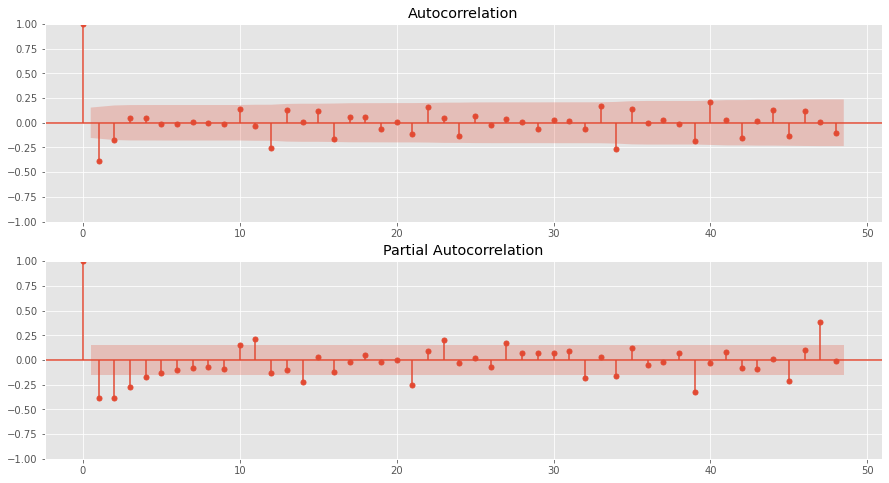

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8)) 

sm.graphics.tsa.plot_acf(data.sales_boxcox_diff2[13:].values.squeeze(), lags=48, ax=ax1)
sm.graphics.tsa.plot_pacf(data.sales_boxcox_diff2[13:].values.squeeze(), lags=48, ax=ax2)

plt.show()

Согласно этим графикам, в качестве начальных значений необходимо взять: $Q=1$, $q=2$, $P=0$, $p=4$. Но так как у нас немного факторов + смушает наличие чередующегося значимого лага у частной автокорреляции. Поэтому как бейзлайн возьмём $P=2$.

### 5. Перебор и сравнение моделей для всех $p,q$ и $P,Q$, которые меньше или равны начальным значениям

In [43]:
# создадим список из значений параметров для перебора моделей

s = 12 # сезонность
d = 1
D = 1
ps = range(0, 4+1)
qs = range(0, 2+1)

Ps = range(0, 2+1)
Qs = range(0, 1+1)

parameters = product(ps ,qs, Ps, Qs)
parameters_list = list(parameters)

parameters_list[:10]

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 1, 0),
 (0, 1, 1, 1)]

In [44]:
# посмотрим, сколько моделей нам предстоит обучить

len(parameters_list)

90

In [45]:
parameters_list[-4:]

[(4, 2, 1, 0), (4, 2, 1, 1), (4, 2, 2, 0), (4, 2, 2, 1)]

In [46]:
from tqdm.notebook import tqdm

In [47]:
data.head()

,sales,lag_2,lag_12,lag_0,lag_1,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,sales_boxcox,sales_boxcox_diff,sales_boxcox_diff2
month,,,,,,,,,,,,,,,,,,,,,
1980-01-01,15136,NaN,NaN,15136,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.999039,NaN,NaN
1980-02-01,16733,NaN,NaN,16733,15136.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.989418,NaN,NaN
1980-03-01,20016,15136.0,NaN,20016,16733.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.817814,NaN,NaN
1980-04-01,17708,16733.0,NaN,17708,20016.0,15136.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.559064,NaN,NaN
1980-05-01,18019,20016.0,NaN,18019,17708.0,16733.0,15136.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.735723,NaN,NaN


In [48]:
d, D, s

(1, 1, 12)

In [49]:
p=q=Q=P=1

In [50]:
odel=sm.tsa.statespace.SARIMAX(data.sales_boxcox,  #sales_boxcox или sales
            order=(p, d, q), 
            seasonal_order=(P, D, Q, s))#.fit(disp=-1)
    

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [51]:
odel.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43057D+00    |proj g|=  1.58749D-01

At iterate    5    f=  1.36905D+00    |proj g|=  5.71132D-02

At iterate   10    f=  1.33909D+00    |proj g|=  2.00722D-02

At iterate   15    f=  1.33148D+00    |proj g|=  2.12962D-02

At iterate   20    f=  1.33111D+00    |proj g|=  7.05302D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   4.081D-06   1.331D+00
  F =   1.3311114324623252     

CONVERG

In [52]:
# SARIMAX(p,d,q)x(P,D,Q,s)
results = [] # здесь будем хранить результаты
warnings.filterwarnings('ignore') # не для всех параметров модели будут обучаться; отключим предупреждения

for param in tqdm(parameters_list):
    #try-except нужен, чтобы обработать случаи, когда модель не обучается
    p, q, P, Q = param
    try:
        model=sm.tsa.statespace.SARIMAX(data.sales_boxcox,  #sales_boxcox или sales
            order=(p, d, q), 
            seasonal_order=(P, D, Q, s)).fit(disp=-1)
    
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])

  0%|          | 0/90 [00:00<?, ?it/s]

In [53]:
# преобразуем результаты в DataFrame и добавим названия столбцов

result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'AIC']

In [54]:
# выведем 5 лучших по AIC моделей 

result_table.sort_values(by = 'AIC', ascending=True).head()

,Parameters,AIC
43,"(2, 1, 0, 1)",474.828532
45,"(2, 1, 1, 1)",475.813087
67,"(3, 2, 0, 1)",476.194725
49,"(2, 2, 0, 1)",476.310856
61,"(3, 1, 0, 1)",476.750432


Лучшей моделью получилась SARIMA (2,1,1)x(0,1,1). Именно на ней мы и остановимся. Заметим, что следующие по AIC модели имеют больше параметров, а чем больше параметров у модели — тем более она неустойчива и тем хуже ее вероятностные свойства. Поэтому иногда, если AIC у двух моделей отличается незначительно, то отдать предпочтение нужно той, которая содержит меньше параметров. Так, иногда, стоит выбирать модели, которые находятся на 2-3 месте.

In [55]:
best_model = sm.tsa.statespace.SARIMAX(data.sales_boxcox, 
                                     order=(2,1,1), 
                                     seasonal_order=(0,1,1,12)).fit(disp=-1)

In [56]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       sales_boxcox   No. Observations:                  176
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -232.414
Date:                            Fri, 15 Jul 2022   AIC                            474.829
Time:                                    02:28:47   BIC                            490.297
Sample:                                01-01-1980   HQIC                           481.109
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1506      0.085     -1.763      0.078      -0.318       0.017
ar.L2         -0.1990      0.111   

### 6. Анализ остатков

Чтобы убедится, что модель хорошая, осталось проанализировать остатки. Сначала посмотрим на них.

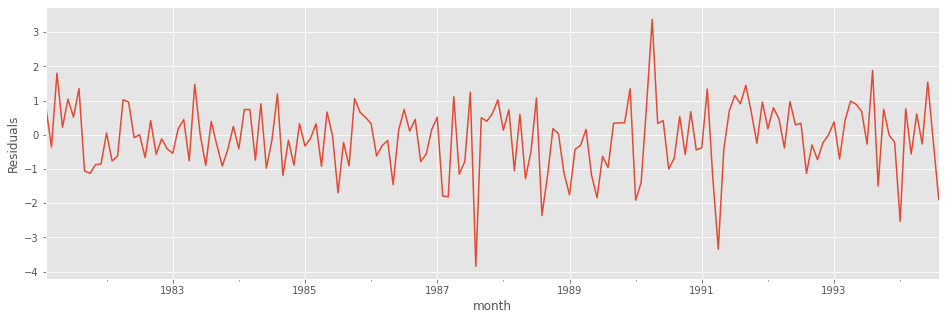

In [57]:
plt.figure(figsize(16,5))
best_model.resid[13:].plot()
plt.ylabel('Residuals')
plt.show()

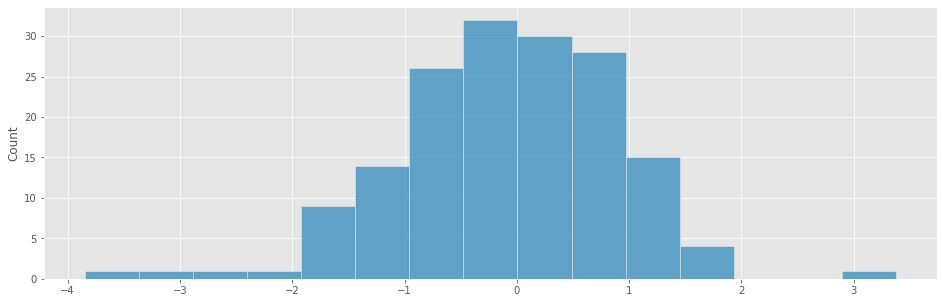

In [58]:
sns.histplot(best_model.resid[13:]);

Визуально остатки выглядят хорошо. Не видны признаки смещенности, нестационарности или какой-либо зависимости.

**Несмещенность.** Проверим несмещенность с помощью критерия знаков (самый универсальный критерий).

In [59]:
from statsmodels.stats.descriptivestats import sign_test
print("Критерий знаков для остатков: pvalue =",
      sign_test(best_model.resid[13:])[1])

Критерий знаков для остатков: pvalue = 0.754160389805438


**Стационарность.** Проверим стационарность с помщью критерия Дики-Фуллера.

In [60]:
print("Критерий Дики-Фуллера для остатков: pvalue =",
      sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Дики-Фуллера для остатков: pvalue = 1.846359534409481e-23


**Неавтокоррелированность.** Чтобы определить независимость остаткок, посмотрим на график автокорреляционной функции.

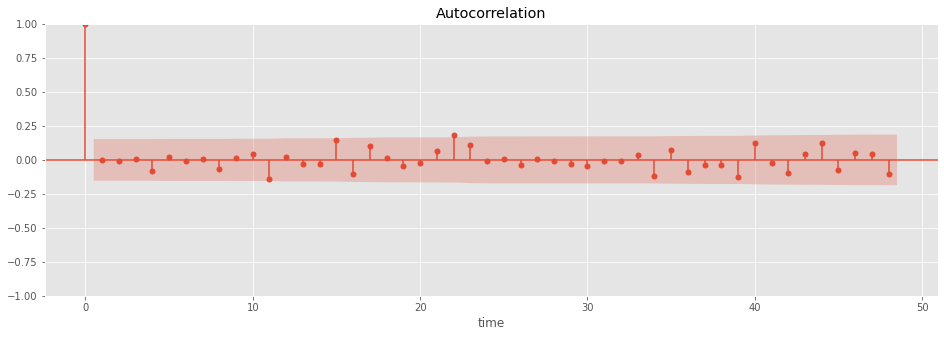

In [61]:
fig, ax = plt.subplots(figsize=(16,5))
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
ax.set_xlabel('time')
plt.show()

Еще обратим внимание, что в summary содержалась информация о Q-критерии Льюнга-Бокса. Этот тест не отвергает нулевую гипотезу о независимости остатков. 

#### График модель + ряд

Выведем на графике наш ряд и построенную для него модель. Для этого необходимо сделать обратное преобразование Бокса.

In [62]:
# сохраним значения нашей модели (не забудем сделать обратное преобразование Бокса-Кокса)

data['model'] = inv_boxcox(best_model.fittedvalues, lmbd)

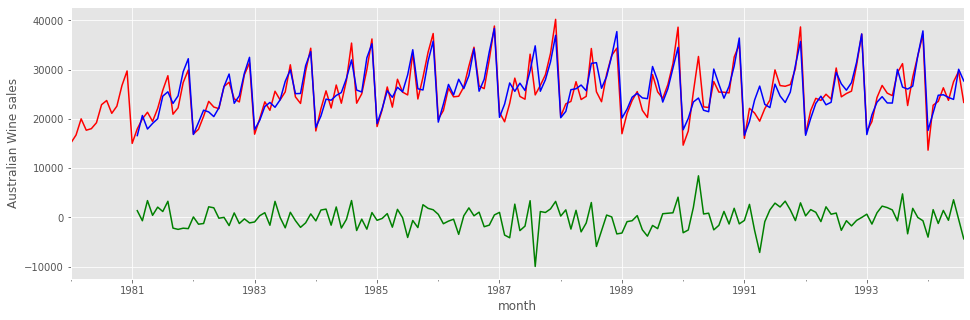

In [63]:
plt.figure(figsize(16,5))
data.sales.plot(color='r')
data.model[13:].plot(color='b')


(data.sales-data.model[13:]).plot(color='g')



plt.ylabel('Australian Wine sales')
pylab.show()

#### Прогноз

Чтобы сделать прогноз, необходимо воспользоваться функцией predict. Так как у DataFrame индексами являются даты, нам необходимо еще записать даты для прогноза. Будем хранить значения ряда и прогноза в new_data.

In [64]:
# сделаем подготовительную работу

plot_data = data[['sales','model']]

date_list = [datetime.datetime.strptime("1994-09-01", "%Y-%m-%d") + relativedelta(months=x) 
             for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= plot_data.columns)
plot_data = pd.concat([plot_data, future])

plot_data.tail()

,sales,model
1997-04-01,NaN,NaN
1997-05-01,NaN,NaN
1997-06-01,NaN,NaN
1997-07-01,NaN,NaN
1997-08-01,NaN,NaN


In [65]:
# сколько дней было при обучении модели
start = data.shape[0]
start

176

In [66]:
# построим предсказание, сделаем для него обратное преобразование Бокса-Кокса

forecast = inv_boxcox(best_model.predict(start=start, end=start+35), lmbd)
forecast.index = date_list

In [67]:
# запишем его в столбец Model

plot_data.loc[date_list, 'model'] = forecast

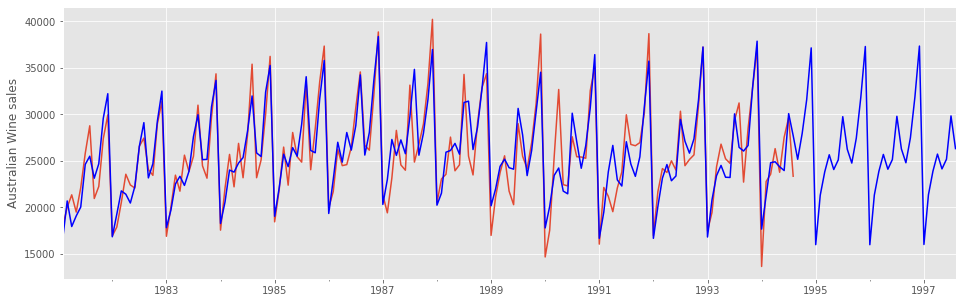

In [68]:
plt.figure(figsize(16,5))
plot_data.sales[13:].plot()
plot_data.model[13:].plot(color='b')
plt.ylabel('Australian Wine sales')
pylab.show()

## Как можно генерировать лаговые переменные

In [69]:
df = pd.read_csv("wine.csv", sep=',', 
                   index_col=['month'], parse_dates=['month'], dayfirst=False) 

df.head()

,sales
month,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


In [70]:
for i in range(1,3):
    df[f'lag_{i}'] = df['sales'].shift(i)
    
for i in range(1,3):
    df[f'lag_s_{i*12}'] = df['sales'].shift(i*12)
    
    
df[f'lag_1_window_{12}'] = df['sales'].shift(1).rolling(window=12).mean()

In [71]:
df.head(20)

,sales,lag_1,lag_2,lag_s_12,lag_s_24,lag_1_window_12
month,,,,,,
1980-01-01,15136,NaN,NaN,NaN,NaN,NaN
1980-02-01,16733,15136.0,NaN,NaN,NaN,NaN
1980-03-01,20016,16733.0,15136.0,NaN,NaN,NaN
1980-04-01,17708,20016.0,16733.0,NaN,NaN,NaN
1980-05-01,18019,17708.0,20016.0,NaN,NaN,NaN
1980-06-01,19227,18019.0,17708.0,NaN,NaN,NaN
1980-07-01,22893,19227.0,18019.0,NaN,NaN,NaN
1980-08-01,23739,22893.0,19227.0,NaN,NaN,NaN
1980-09-01,21133,23739.0,22893.0,NaN,NaN,NaN


In [72]:
df.dropna()

,sales,lag_1,lag_2,lag_s_12,lag_s_24,lag_1_window_12
month,,,,,,
1982-01-01,16933,29945.0,27392.0,15028.0,15136.0,22594.750000
1982-02-01,17892,16933.0,29945.0,17977.0,16733.0,22753.500000
1982-03-01,20533,17892.0,16933.0,20008.0,20016.0,22746.416667
1982-04-01,23569,20533.0,17892.0,21354.0,17708.0,22790.166667
1982-05-01,22417,23569.0,20533.0,19498.0,18019.0,22974.750000
...,...,...,...,...,...,...
1994-04-01,26323,23565.0,22784.0,26805.0,23757.0,26553.500000
1994-05-01,23779,26323.0,23565.0,25236.0,25013.0,26513.333333
1994-06-01,27549,23779.0,26323.0,24735.0,24019.0,26391.916667


## Как можно делать кросс-валидацию

Реализация в sklearn [тут](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit)

![](https://camo.githubusercontent.com/80671ee5b06b50aea07e550b06490a1d5d9c23332c6d718fc08423a9b45b4151/68747470733a2f2f692e6962622e636f2f4b576b665137712f6e6577706c6f742e706e67)
![](https://camo.githubusercontent.com/2c891a4301fbab51ef1c2584e2f4eb1ea30fb2e24c703f22ad46f2d62ce4702d/68747470733a2f2f692e6962622e636f2f5a6d524e4c35322f6e6577706c6f742d312e706e67)